## End of distribution Imputation ==> Feature-Engine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import EndTailImputer

In [2]:
cols_to_use = ['BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice']
data = pd.read_csv('housingPrices_train.csv', usecols=cols_to_use)
data.head()

,LotFrontage,MasVnrArea,BsmtQual,FireplaceQu,GarageYrBlt,SalePrice
0,65.0,196.0,Gd,NaN,2003.0,208500
1,80.0,0.0,Gd,TA,1976.0,181500
2,68.0,162.0,Gd,TA,2001.0,223500
3,60.0,0.0,TA,Gd,1998.0,140000
4,84.0,350.0,Gd,TA,2000.0,250000


In [3]:
data.isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
BsmtQual       0.025342
FireplaceQu    0.472603
GarageYrBlt    0.055479
SalePrice      0.000000
dtype: float64

**All the predictor variables contain missing data!**

In [4]:
cols_to_use.remove('SalePrice')
X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 5), (438, 5))

### Feature-Engine captures the numerical variables automatically

** Call the **imputer from feature-engine**! Specify whether we want to find the values using the **gaussian approximation** or the **inter-quantal range proximity rule**! The values placed at the **left or right tail?**

In [5]:
imputer = EndTailImputer(imputation_method='gaussian', tail='right')

**Fit the imputer!..**

In [6]:
imputer.fit(X_train)

EndTailImputer()

**The imputer finds the numerical variables to impute with the end of distribution value!**

In [7]:
imputer.variables_

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

**See the values that will be used to replace NA for each variable!**

In [8]:
imputer.imputer_dict_

{'LotFrontage': 138.9022201686726,
 'MasVnrArea': 648.3947111415157,
 'GarageYrBlt': 2052.9707419772235}

**Gaussian approximation values!**

In [9]:
X_train[imputer.variables_].mean() + 3 * X_train[imputer.variables_].std()

LotFrontage     138.902220
MasVnrArea      648.394711
GarageYrBlt    2052.970742
dtype: float64

**feature-engine returns a dataframe!**

In [10]:
tmp = imputer.transform(X_train)
tmp.head()

,BsmtQual,FireplaceQu,LotFrontage,MasVnrArea,GarageYrBlt
64,Gd,NaN,138.90222,573.0,1998.000000
682,Gd,Gd,138.90222,0.0,1996.000000
960,TA,NaN,50.00000,0.0,2052.970742
1384,TA,NaN,60.00000,0.0,1939.000000
1100,TA,NaN,60.00000,0.0,1930.000000


**Check that the numerical variables don't contain NA any more!..**

In [11]:
tmp[imputer.variables_].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
dtype: float64

## Feature-engine allows you to specify variable groups easily

**Do imputation over 2 of the 3 numerival variables! Select the proximity rule on the left tail!..**

In [12]:
imputer = EndTailImputer(imputation_method='iqr', tail='left',
                         variables=['LotFrontage', 'MasVnrArea'])
imputer.fit(X_train)

EndTailImputer(imputation_method='iqr', tail='left',
               variables=['LotFrontage', 'MasVnrArea'])

**Imputer uses only the variables we indicated!**

In [13]:
imputer.variables_

['LotFrontage', 'MasVnrArea']

**See the value assigned to each variable!**

In [14]:
imputer.imputer_dict_

{'LotFrontage': -8.0, 'MasVnrArea': -510.0}

**feature-engine returns a dataframe! Check null values are gone!**

In [15]:
tmp = imputer.transform(X_train)
tmp[imputer.variables_].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

## Feature-engine can be used with the Scikit-learn pipeline

**Look at the distributions to determine the end tail value selection method!**

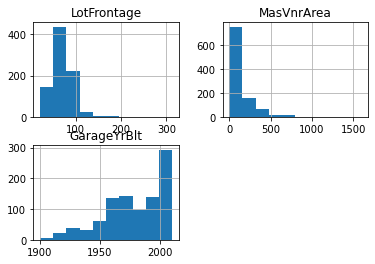

In [16]:
X_train.hist()
plt.show()

All variables are skewed. For this demo, I will use the proximity rule for GarageYrBlt and MasVnrArea, and the Gaussian approximation for LotFrontage.

In [17]:
pipe = Pipeline([
    ('imputer_skewed', EndTailImputer(imputation_method='iqr', tail='right',
                                      variables=['GarageYrBlt', 'MasVnrArea'])),
    ('imputer_gaussian', EndTailImputer(imputation_method='gaussian', tail='right',
                                        variables=['LotFrontage'])),])

In [18]:
pipe.fit(X_train)

Pipeline(steps=[('imputer_skewed',
                 EndTailImputer(imputation_method='iqr',
                                variables=['GarageYrBlt', 'MasVnrArea'])),
                ('imputer_gaussian',
                 EndTailImputer(variables=['LotFrontage']))])

In [19]:
pipe.named_steps['imputer_skewed'].imputer_dict_

{'GarageYrBlt': 2121.0, 'MasVnrArea': 680.0}

In [20]:
pipe.named_steps['imputer_gaussian'].imputer_dict_

{'LotFrontage': 138.9022201686726}

**Transform the data with the pipeline! Check null values are gone!**

In [21]:
tmp = pipe.transform(X_train)
tmp.isnull().mean()

BsmtQual       0.023483
FireplaceQu    0.467710
LotFrontage    0.000000
MasVnrArea     0.000000
GarageYrBlt    0.000000
dtype: float64

There are no more null values for the 3 imputed numerical variables.